In [1]:
from pathlib import Path
import torch
import taichi as ti
import numpy as np
import os

from torchvtk.datasets import TorchDataset
from torchvtk.utils import make_4d, tex_from_pts, TFGenerator
from torchvtk.rendering import plot_tf

from differender.utils import get_tf, in_circles, get_rand_pos
from differender.volume_raycaster import Raycaster, Mode
import matplotlib.pyplot as plt

[Taichi] version 0.8.5, llvm 10.0.0, commit 45c6ad48, linux, python 3.7.11
[I 03/25/22 06:38:44.600 4257] [shell.py:_shell_pop_print@34] Graphical python shell detected, using wrapped sys.stdout
[TaiGLSL] version 0.0.11


In [28]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        ax.set_title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

def show_all_ims(render):
    fig, ax = plt.subplot_mosaic([['full_rgb', 'full_a', 'full_d'],
                                  ['l1_rgb', 'l1_a', 'l1_d'],
                                  ['l2_rgb', 'l2_a', 'l2_d'],
                                  ['l3_rgb', 'l3_a', 'l3_d'],
                                 ], figsize=(15,20))
    ax['full_rgb'].imshow(render[:3].permute(1,2,0))
    ax['full_rgb'].set_title('Full RGB')
    ax['full_rgb'].set_axis_off()
    ax['full_a'].imshow(render[[3]].permute(1,2,0))
    ax['full_a'].set_title('Full Alpha')
    ax['full_a'].set_axis_off()
    ax['full_d'].imshow(render[[4]].permute(1,2,0))
    ax['full_d'].set_title('Full Depth')
    ax['full_d'].set_axis_off()
    
    ax['l1_rgb'].imshow(render[7:10].permute(1,2,0))
    ax['l1_rgb'].set_title('Layer 1 RGB')
    ax['l1_rgb'].set_axis_off()
    ax['l1_a'].imshow(render[[10]].permute(1,2,0))
    ax['l1_a'].set_title('Layer 1 Alpha')
    ax['l1_a'].set_axis_off()
    ax['l1_d'].imshow(render[[4]].permute(1,2,0))
    ax['l1_d'].set_title('Layer 1 Depth')
    ax['l1_d'].set_axis_off()
    
    ax['l2_rgb'].imshow(render[11:14].permute(1,2,0))
    ax['l2_rgb'].set_title('Layer 2 RGB')
    ax['l2_rgb'].set_axis_off()
    ax['l2_a'].imshow(render[[14]].permute(1,2,0))
    ax['l2_a'].set_title('Layer 2 Alpha')
    ax['l2_a'].set_axis_off()
    ax['l2_d'].imshow(render[[5]].permute(1,2,0))
    ax['l2_d'].set_title('Layer 2 Depth')
    ax['l2_d'].set_axis_off()
    
    ax['l3_rgb'].imshow(render[15:18].permute(1,2,0))
    ax['l3_rgb'].set_title('Layer 3 RGB')
    ax['l3_rgb'].set_axis_off()
    ax['l3_a'].imshow(render[[18]].permute(1,2,0))
    ax['l3_a'].set_title('Layer 3 Alpha')
    ax['l3_a'].set_axis_off()
    ax['l3_d'].imshow(render[[6]].permute(1,2,0))
    ax['l3_d'].set_title('Layer 3 Depth')
    ax['l3_d'].set_axis_off()

In [30]:
ivw_export = Path('/home/dome/Dev/SemiTransparentDepth/test_data/inviwo_export')
pred_path = ivw_export.parent/'predictions'

W, H = 512, 512
TF_RES = 256
SR = 8.0 # Sampling rate
BINS = 101
MODE = Mode.WYSIWYP
ti_kwargs = {'device_memory_fraction':0.3}

In [4]:
fns = [ivw_export/dir for dir in os.listdir(ivw_export) if (ivw_export/dir).is_dir()]


In [16]:
vol = np.load(fns[0]/'vol.npy', allow_pickle=True)
vol_scl = np.load(fns[0]/'vol_scl.npy', allow_pickle=True)
tf  = np.load(fns[0]/'tf.npy', allow_pickle=True)
cam = np.load(fns[0]/'lf.npy', allow_pickle=True)

vol = make_4d(torch.from_numpy(vol).permute(1,2,0).float()).cuda()
tf = tex_from_pts(torch.from_numpy(tf).float().cuda(), TF_RES)
tf[3] *= 
cam = torch.from_numpy(cam).float().cuda()

Volume: torch.Size([1, 512, 460, 512]) 0.0 1.0
Volume Scale: [1.       1.       1.113043]
Camera: tensor([ 1.0241e+00, -2.8197e+00,  7.7214e-04], device='cuda:0')


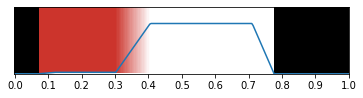

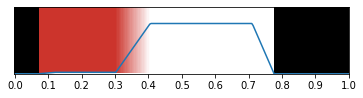

In [17]:
print('Volume:', vol.shape, vol.min().item(), vol.max().item())
print('Volume Scale:', vol_scl)
print('Camera:', cam)
plot_tf(tf)

In [18]:
raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, 
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, mode=MODE, ti_kwargs=ti_kwargs)

[Taichi] Starting on arch=cuda


In [19]:
rgba = raycaster.raycast_nondiff(vol, tf, cam, sampling_rate=1.0).squeeze(0).rot90(1, dims=(-1,-2)).cpu()

In [21]:
rgba.max()

tensor(1.1990)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


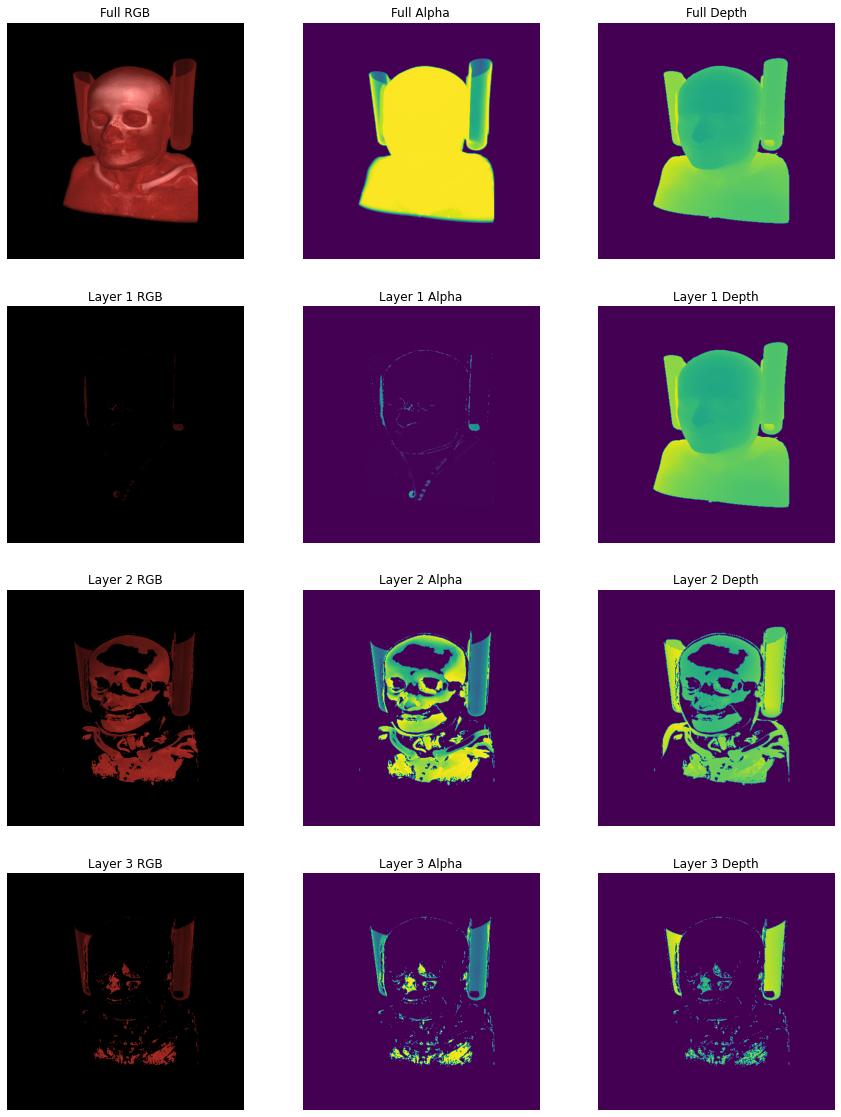

In [22]:
show_all_ims(rgba.cpu())